In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from feature_transform import max_transformer
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [25]:
dirs = ["db5_saliency_warmstart_seed=1"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave="db5", mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [26]:
dics = []
for i in range(len(dirs)):
    # define indexes
    res = results[i]
    mos = models[i]
    lamL1wave = np.array(res['lamL1wave'])
    lamL1attr = np.array(res['lamL1attr'])
    lamL1wave_grid = np.unique(lamL1wave)
    lamL1attr_grid = np.unique(lamL1attr)
    R = len(lamL1wave_grid)
    C = len(lamL1attr_grid)

    # collect results
    dic = {'psi':{},
           'wt': {},
           'x': {},
           'lamL1wave': {},
           'lamL1attr': {},
           'index': {}}

    for r in range(R):
        for c in range(C):
            loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
            if loc.sum() == 1: 
                loc = np.argwhere(loc).flatten()[0]
                dic['index'][(r,c)] = loc
                wt = mos[loc]
                _, psi, x = get_wavefun(wt)

                dic['wt'][(r,c)] = wt
                dic['psi'][(r,c)] = psi  
                dic['x'][(r,c)] = x
                dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
                dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]
    dics.append(dic)

# calculate accuracy

In [27]:
# params for feature transformer
sgn = "pos"
m = 6

# cross validation
reg_score = []
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)   

index = 0 # select which result to evaluate
for i,wt in enumerate(list(dics[index]['wt'].values())):
    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = max_transformer(wt, 
                                               train_loader, 
                                               test_loader,
                                               sgn=sgn,
                                               m=m)


    clf = LinearRegression()
    scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
    reg_score.append(scores.mean())
    print('\rIteration:{}'.format(i), end='')
reg_score = np.array(reg_score)

Iteration:104

Hyperparameter: lamL1wave=0.005000 lamL1attr=0.042810
Error: Recon=0.000215
Sparsity: Wave=3.938666
Interp: Saliency=0.374978 InputXGrade=0.286363
Wavelet loss: lSum=0.000000 hsum=0.000000 L2norm=0.000000 CMF=0.000003 Conv=0.000000


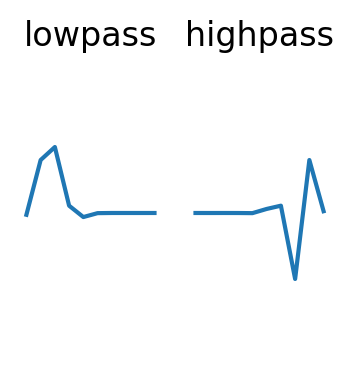

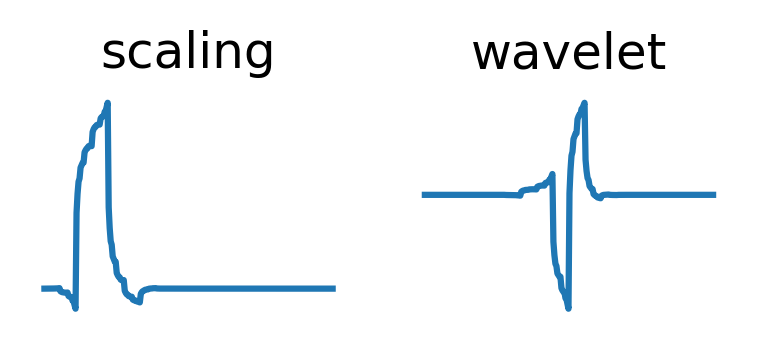

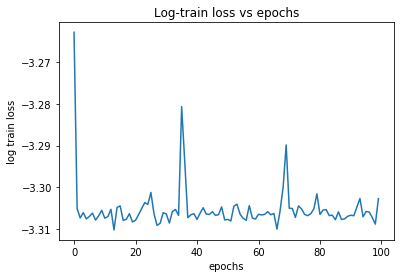

In [28]:
idx1, idx2 = list(dics[index]['wt'].keys())[np.argmax(reg_score).flatten()[0]]
idx = dics[index]['index'][(idx1, idx2)]
wt = models[index][idx].to('cpu')
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(results[index]['lamL1wave'][idx], results[index]['lamL1attr'][idx]))
print('Error: Recon={:.6f}'.format(results[index]['rec_loss'][idx]))
print('Sparsity: Wave={:.6f}'.format(results[index]['L1wave_loss'][idx]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(results[index]['L1saliency_loss'][idx], results[index]['L1inputxgrad_loss'][idx]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(results[index]['lsum_loss'][idx],
                                                                                          results[index]['hsum_loss'][idx],
                                                                                          results[index]['L2norm_loss'][idx],
                                                                                          results[index]['CMF_loss'][idx],
                                                                                          results[index]['conv_loss'][idx]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

plt.plot(np.log(res['train_losses'][dic['index'][(idx1, idx2)]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [47]:
def r2_bootstrap(y, y_pred, m=10000):
    """Return bootstrap mean and std error."""
    np.random.seed(p.seed)
    e = []
    for j in range(m):
        idx = np.arange(len(y))
        sel = np.random.choice(idx, len(idx), replace=True)
        e.append(metrics.r2_score(y[sel],y_pred[sel]))
    return metrics.r2_score(y_test, preds), np.std(e)

In [51]:
model = load_pretrained_model(p.model_path, device=device)    

r = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],    
    'LSTM': [],
}

p.batch_size = 3000
(train_loader, test_loader) = get_dataloader(p.data_path, 
                             batch_size=p.batch_size,
                             is_continuous=True)   

(X, y), (X_test, y_test) = max_transformer(wt, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf = LinearRegression().fit(X, y)
start_time = time.time()
preds = clf.predict(X_test)
print("AWD took", time.time() - start_time, "to run")
acc, std = r2_bootstrap(y_test, preds)
print('AWD Std:', std.round(3))
r['AWD (Ours)'].append(acc)

wt_o = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0)
(X, y), (X_test, y_test) = max_transformer(wt_o, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf_o = LinearRegression().fit(X, y)
start_time = time.time()
preds = clf_o.predict(X_test)
print("AWD took", time.time() - start_time, "to run")
acc, std = r2_bootstrap(y_test, preds)
print('DB5 Std:', std.round(3))
r['Standard Wavelet (DB5)'].append(acc)

start_time = time.time()
preds = []
y_test = []
for data, labels in test_loader:   
    preds.append(model(data).detach().numpy())
    y_test.append(labels.detach().numpy())
preds = np.vstack(preds)
y_test = np.vstack(y_test)
print("AWD took", time.time() - start_time, "to run")
acc, std = r2_bootstrap(y_test, preds)
print('LSTM Std:', std.round(3))
r['LSTM'].append(acc)

scores = pd.DataFrame.from_dict(r).round(3)
scores.index = ['Regression (R2 score)']
print(scores.to_latex())

AWD took 0.0004074573516845703 to run
AWD Std: 0.026
AWD took 0.00040030479431152344 to run
DB5 Std: 0.028
AWD took 0.06494569778442383 to run
LSTM Std: 0.032
\begin{tabular}{lrrr}
\toprule
{} &  Standard Wavelet (DB5) &  AWD (Ours) &   LSTM \\
\midrule
Regression (R2 score) &                   0.197 &       0.263 &  0.237 \\
\bottomrule
\end{tabular}

